In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Make sure the optimizer is in the path
import sys
sys.path.append('../optimizer')
from belavkin_optimizer import BelavkinOptimizer

In [3]:
# 1. Non-Markovian Quadratic Optimization
class NonMarkovianQuadratic:
    def __init__(self, dim=10, memory_len=5):
        self.dim = dim
        self.memory_len = memory_len
        self.Q = torch.randn(dim, dim)
        self.Q = 0.5 * (self.Q + self.Q.t())  # Ensure symmetry
        self.x_history = []

    def get_loss(self, x):
        self.x_history.append(x.detach().clone())
        if len(self.x_history) > self.memory_len:
            self.x_history.pop(0)
        
        main_term = 0.5 * torch.einsum('ij,i,j->', self.Q, x.squeeze(), x.squeeze())
        
        memory_term = 0.0
        if len(self.x_history) > 1:
            for i in range(len(self.x_history) - 1):
                memory_term += torch.dot(self.x_history[i].squeeze(), self.x_history[i+1].squeeze())
        
        return main_term + 0.1 * memory_term

In [4]:
# 2. Modular Arithmetic Task (Addition)
class ModularAddition:
    def __init__(self, modulus=7):
        self.modulus = modulus
        self.a = np.random.randint(0, modulus)
        self.b = np.random.randint(0, modulus)
        self.c = (self.a + self.b) % modulus

    def get_loss(self, x):
        prediction = torch.round(x) % self.modulus
        return (prediction - self.c)**2

In [5]:
# 3. Multi-Objective Quadratic Problem
class MultiObjectiveQuadratic:
    def __init__(self, dim=10, n_objectives=3, rank=3):
        self.dim = dim
        self.n_objectives = n_objectives
        self.Qs = []
        for _ in range(n_objectives):
            A = torch.randn(dim, rank)
            Q = torch.matmul(A, A.t())
            self.Qs.append(Q)

    def get_loss(self, x):
        total_loss = 0
        for Q in self.Qs:
            total_loss += 0.5 * torch.einsum('ij,i,j->', Q, x.squeeze(), x.squeeze())
        return total_loss

In [6]:
# Function to run the optimization
def run_optimizer(optimizer_class, objective, n_steps=100, dim=10, **optimizer_kwargs):
    x = torch.randn(dim, 1, requires_grad=True)
    optimizer = optimizer_class([x], **optimizer_kwargs)
    losses = []
    
    for _ in range(n_steps):
        optimizer.zero_grad()
        loss = objective.get_loss(x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return losses

In [7]:
# --- Benchmarking ---
# 1. Non-Markovian Quadratic
nm_objective = NonMarkovianQuadratic()
belavkin_losses_nm = run_optimizer(BelavkinOptimizer, nm_objective)
adam_losses_nm = run_optimizer(optim.Adam, nm_objective)
sgd_losses_nm = run_optimizer(optim.SGD, nm_objective, lr=1e-3)

In [8]:
# 2. Modular Addition
ma_objective = ModularAddition()
belavkin_losses_ma = run_optimizer(BelavkinOptimizer, ma_objective, dim=1)
adam_losses_ma = run_optimizer(optim.Adam, ma_objective, dim=1)
sgd_losses_ma = run_optimizer(optim.SGD, ma_objective, dim=1, lr=1e-3)

In [9]:
# 3. Multi-Objective Quadratic
mo_objective = MultiObjectiveQuadratic()
belavkin_losses_mo = run_optimizer(BelavkinOptimizer, mo_objective)
adam_losses_mo = run_optimizer(optim.Adam, mo_objective)
sgd_losses_mo = run_optimizer(optim.SGD, mo_objective, lr=1e-3)

In [10]:
# --- Plotting ---
plt.figure(figsize=(18, 5))

<Figure size 1800x500 with 0 Axes>

<Figure size 1800x500 with 0 Axes>

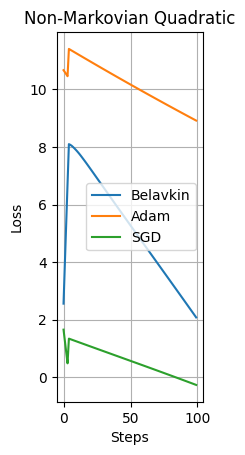

In [11]:
plt.subplot(1, 3, 1)
plt.plot(belavkin_losses_nm, label='Belavkin')
plt.plot(adam_losses_nm, label='Adam')
plt.plot(sgd_losses_nm, label='SGD')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Non-Markovian Quadratic')
plt.legend()
plt.grid(True)

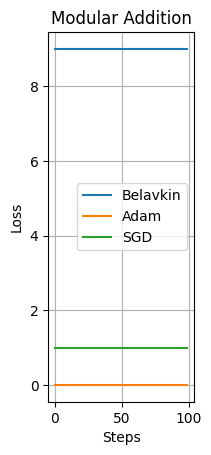

In [12]:
plt.subplot(1, 3, 2)
plt.plot(belavkin_losses_ma, label='Belavkin')
plt.plot(adam_losses_ma, label='Adam')
plt.plot(sgd_losses_ma, label='SGD')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Modular Addition')
plt.legend()
plt.grid(True)

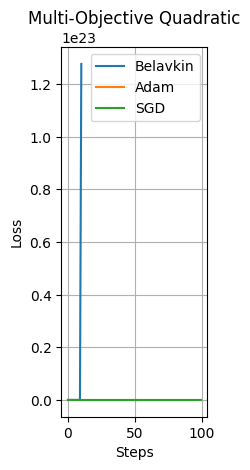

In [13]:
plt.subplot(1, 3, 3)
plt.plot(belavkin_losses_mo, label='Belavkin')
plt.plot(adam_losses_mo, label='Adam')
plt.plot(sgd_losses_mo, label='SGD')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Multi-Objective Quadratic')
plt.legend()
plt.grid(True)

In [14]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>